# Can an Investor Beat the Market Using Machine Learning?

In [650]:
# import packages and filter warnings
import pandas as pd
import numpy as np
import math
import sklearn
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
import yfinance as yf
import talib
import datetime
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix
from numpy import vstack
import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import blitz
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from keras import optimizers

warnings.filterwarnings('ignore')

## Foundation Data Preprocessing

In [ ]:
# import fundamental data
# funds = pd.read_csv('Final Project Fundamentals.csv')

In [ ]:
# # clean fundamental data
# funds['mktcap'] = funds['csh12q'] * funds['prccq']
# funds['DE_ratio'] = funds['dlttq'] / funds['mktcap']
# funds.drop(['consol','popsrc','costat','datafmt','indfmt','GVKEY'],axis =1, inplace = True)
# funds['BookMark_ratio'] = funds['teqq'] / funds['mktcap']
# funds['EPS_growth'] = (funds.groupby('LPERMNO')['epspiq'].shift(0) - funds.groupby('LPERMNO')['epspiq'].shift(1))/abs(funds.groupby('LPERMNO')['epspiq'].shift(1))
# funds['OP_margin'] = funds['oibdpq'] / funds['revtq']
# funds.drop(['curcdq','datacqtr','csh12q','dlttq','epspiq','oibdpq','revtq','teqq','prccq'],axis=1,inplace=True)
# # avoid lookahead bias in fundamental data
# funds['datadate'] = pd.to_datetime(funds['datadate']) + pd.DateOffset(months=3)
# funds.fillna(0, inplace=True)
# funds['month'] = pd.to_datetime(funds['datadate']).dt.strftime('%m')
# funds['year'] = pd.to_datetime(funds['datadate']).dt.strftime('%Y')
# ls = []
# for i in funds['month']:
#     if int(i) < 4:
#         ls.append(1)
#     elif int(i) > 3 and int(i) < 7:
#         ls.append(2)
#     elif int(i) > 6 and int(i) < 10:
#         ls.append(3)
#     else:
#         ls.append(4)
# funds['quarter'] = ls
# funds = funds[['LPERMNO','datadate','conm','mktcap','DE_ratio','BookMark_ratio','EPS_growth','OP_margin','quarter','year']]

In [ ]:
# Pull in Treasury Rates for Various Maturities
rates = pd.read_csv('Treasury_Rates.csv')

In [ ]:
# Clean rate data
rates.set_index('DATE',inplace=True)
rates.fillna(0, inplace=True)

In [ ]:
# Pull in Corporate Bond Yields
corp_yield = pd.read_csv('Corp_yields.csv')
corp_yield.set_index('DATE',inplace=True)

In [ ]:
# Import market indexes and commodities
indexes = pd.read_csv('Market_Indexes.csv')
indexes.dropna(subset=['Date'],axis=0,inplace=True)

In [ ]:
# get rid of some bad Gold data
indexes.set_index('Date',inplace=True)
indexes['GOLD'] = pd.to_numeric(indexes['GOLD'],errors='coerce')

In [ ]:
# use interpolation to fill NaN values
indexes['GOLD'] = indexes['GOLD'].interpolate()
indexes['OIL'] = pd.to_numeric(indexes['OIL'],errors='coerce')
indexes['OIL'] = indexes['OIL'].interpolate()

In [ ]:
# create return data for market indexes and exchange rates
indexes['DJIA_chg'] = indexes['DJIA'].pct_change()
indexes['NASDAQ_chg'] = indexes['NASDAQ'].pct_change()
indexes['Shang_chg'] = indexes['Shanghai Ind'].pct_change()
indexes['DAX_chg'] = indexes['Dax Index'].pct_change()
indexes['Hang_chg'] = indexes['Hang Seng Index'].pct_change()
indexes['CAC_chg'] = indexes['CAC Index'].pct_change()
indexes['VIX_chg'] = indexes['VIX'].pct_change()
indexes['Dollar_chg'] = indexes['Dollar Index'].pct_change()
indexes['EurDoll_chg'] = indexes['EuroDollar EXG'].pct_change()
indexes['PouDoll_chg'] = indexes['PoundDollar EXG'].pct_change()
indexes['YenDollar_chg'] = indexes['YenDollar EXG'].pct_change()

indexes['Gold_chg'] = indexes['GOLD'].pct_change()
indexes['Oil_chg'] = indexes['OIL'].pct_change()
indexes.fillna(0,inplace=True)

In [ ]:
# set rate column names
rates.columns = ['1yr','1yr_chg','10yr','10yr_chg','1mo','1mo_chg','2yr','2yr_chg','3yr','3yr_chg','3mo','3mo_chg','5yr','5yr_chg','6mo','6mo_chg','7yr','7yr_chg']

In [ ]:
# combine corporate and treasury yields
yields = rates.merge(corp_yield,how='left',left_index=True,right_index=True)
yields.fillna(0,inplace=True)

In [82]:
# Import S&P500 top 100 companies
filt_ret = pd.read_csv('filtered_returns.csv')

In [83]:
# create month and year columns
filt_ret['month'] = pd.to_datetime(filt_ret['date']).dt.strftime('%m')
filt_ret['year'] = pd.to_datetime(filt_ret['date']).dt.strftime('%Y')

In [84]:
# create a quarter column for merging
ls = []
for i in filt_ret['month']:
    if int(i) < 4:
        ls.append(1)
    elif int(i) > 3 and int(i) < 7:
        ls.append(2)
    elif int(i) > 6 and int(i) < 10:
        ls.append(3)
    else:
        ls.append(4)
filt_ret['quarter'] = ls

In [85]:
# create day spread column
filt_ret['DaySpread'] = filt_ret['ASKHI'] - filt_ret['BIDLO']

In [86]:
# Create 3 and 10 day simple moving averages of volume
vol3 = pd.DataFrame(filt_ret.groupby('PERMNO')['VOL'].rolling(window=3).mean())
vol10 = pd.DataFrame(filt_ret.groupby('PERMNO')['VOL'].rolling(window=10).mean())

In [87]:
# Add volume data to returns
filt_ret = filt_ret.reset_index().merge(vol3.reset_index(),left_on=['index','PERMNO'],right_on=['level_1','PERMNO'])

In [88]:
# Do some more cleaning
filt_ret.rename(columns={'VOL_y':'3dayVOL'},inplace=True)
filt_ret.drop(['level_1','index'],axis=1, inplace=True)

In [89]:
# # Add volume data to returns
filt_ret = filt_ret.reset_index().merge(vol10.reset_index(),left_on=['index','PERMNO'],right_on=['level_1','PERMNO'])

In [90]:
# drop columns
filt_ret.drop(['index','level_1'],axis=1,inplace=True)

In [91]:
# Rename volume columns
filt_ret.rename(columns={'VOL':'10dayVOL'},inplace=True)

In [92]:
# drop unneeded columns
filt_ret.drop(['SHROUT','RETX','month'],axis=1, inplace=True)

In [93]:
# Fill na values
filt_ret.fillna(0,inplace=True)

In [94]:
# create dataframe to add momentum factors
mom_df = pd.DataFrame(data={'date':[],'PERMNO':[],'RSI':[],'WILLR':[]})

In [95]:
# calculate momentum factors
for i in range(0,len(pd.DataFrame(filt_ret.groupby('PERMNO')))):
    temp_df = pd.DataFrame(filt_ret.groupby('PERMNO')).iloc[i,1]
    temp_df['RSI'] = talib.RSI(temp_df['PRC'],timeperiod=14)
    temp_df['WILLR'] = talib.WILLR(temp_df['ASKHI'],temp_df['BIDLO'],temp_df['PRC'],timeperiod=14)
    mom_df = pd.concat([mom_df,temp_df[['PERMNO','date','RSI','WILLR']]])

In [96]:
# add momentum factors to dataset
filt_ret = filt_ret.merge(mom_df,left_on=['PERMNO','date'],right_on=['PERMNO','date'])

In [123]:
# make return data numeric type
filt_ret['RET'] = pd.to_numeric(filt_ret['RET'],errors='coerce')

In [125]:
# drop any returns that could not be transformed to numeric type
filt_ret.dropna(subset=['RET'],how='any',inplace=True)

In [ ]:
# Merge return and fundamental data
stocks = filt_ret.merge(funds, how='left',left_on=['PERMNO','quarter','year'],right_on=['LPERMNO','quarter','year'],suffixes=['_ret','_fund'])
stocks.fillna(0,inplace=True)

In [ ]:
# rename column
stocks.rename(columns={'VOL_x':'DailyVOL'},inplace=True)

In [ ]:
# drop unneeded columns
stocks.drop(['TICKER','BIDLO','ASKHI','year','quarter','datadate','conm','LPERMNO'],axis=1,inplace=True)

In [ ]:
# clear memory
del filt_ret
del funds
del mom_df
del rates
del corp_yield

In [ ]:
# Write data to csv files
stocks.to_csv('stock_data.csv', index=False)
ret.to_csv('sp500_returns.csv',index=False)
indexes.reset_index(inplace=True)
indexes.to_csv('index_returns.csv',index=False)
yields.reset_index(inplace=True)
yields.to_csv('corp_treas_yields.csv',index=False)

## Final Data Preprocessing

In [167]:
# load in data
stocks = pd.read_csv('stock_data.csv')
yields = pd.read_csv('corp_treas_yields.csv')
indexes = pd.read_csv('index_returns.csv')

In [169]:
# reindex date column
indexes.set_index('Date',inplace=True)

In [170]:
# drop unneccessary columns
stocks.drop(['mktcap_ret','PRC','mktcap_fund','DE_ratio','BookMark_ratio','EPS_growth','OP_margin','PERMNO'],axis=1,inplace=True)

In [171]:
# reindex date column
stocks.set_index('date',inplace=True)

In [172]:
# transform all data in the dataframe to numeric type
stocks = stocks.applymap(lambda x: pd.to_numeric(x,errors='coerce'))

In [173]:
# calculatee percentiles of 8 different metrics
perc_df = pd.DataFrame()
for i in range(5,100,5):
    perc_df['PerRET_' + str(i)] = stocks.groupby('date')['RET'].quantile(i/100)
    perc_df['PerVOL_' + str(i)] = stocks.groupby('date')['DailyVOL'].quantile(i/100)
    perc_df['Per3VOL_' + str(i)] = stocks.groupby('date')['3dayVOL'].quantile(i/100)
    perc_df['Per10VOL_' + str(i)] = stocks.groupby('date')['10dayVOL'].quantile(i/100)
    perc_df['PerRSI' + str(i)] = stocks.groupby('date')['RSI'].quantile(i/100)
    perc_df['PerWILLR' + str(i)] = stocks.groupby('date')['WILLR'].quantile(i/100)
    perc_df['PerSpread' + str(i)] = stocks.groupby('date')['DaySpread'].quantile(i/100)

In [175]:
# Reindex date column
yields.set_index('DATE',inplace=True)

In [176]:
# merge the percentile data with the corporate bond and treasury yields
df1 = perc_df.merge(yields, how='left',left_index=True,right_index=True)

In [177]:
# merge the index data with the yields and percentiles
df_final = df1.merge(indexes, how='left',left_index=True,right_index=True)

In [178]:
# write final data set to csv for safe keeping
df_final.reset_index(inplace=True)
df_final.to_csv('final_data_v2.csv',index=False)

In [179]:
# load in data
df_final = pd.read_csv('final_data_v2.csv')

In [182]:
# Reindex date column
df_final.set_index('date',inplace=True)

In [45]:
# Rearrange the column order
df_final = df_final[[c for c in df_final if c not in ['UpDown']] + ['UpDown']]

In [46]:
# Drop unnecessary columns
# df_final.drop([f'PERMNO_{i}' for i in range(0,100)],axis=1,inplace=True)

In [183]:
# Change index to datetime type
df_final.index = pd.to_datetime(df_final.index)

In [184]:
# Replace any infinite data to NaN
df_final = df_final.replace([np.inf,-np.inf],np.NaN)

In [185]:
# All data in dataframe transformed to numeric
df_final = df_final.applymap(lambda x: pd.to_numeric(x,errors='coerce'))

In [186]:
# Make sure any NaNs are transformed using linear interpolation
df_final.astype(float).interpolate(method='time', axis=0,limit_direction='both',inplace=True)

In [187]:
# Fill any left over NaNs
df_final.fillna(0,inplace=True)

### Retrieve SPY data

In [189]:
# gather SPY data from yahoo finance
ret = yf.download('SPY', start='1970-01-01', end='2020-12-31',period='1d')

[*********************100%***********************]  1 of 1 completed


In [190]:
# Calculate return data
ret = ret[ret['Open']>0]
ret['DaySpread'] = ret['High'] - ret['Low']
ret['Ret0'] = ret['Close'].pct_change()
ret['Ret1'] = ret['Ret0'].shift(1)
ret['Ret2'] = ret['Ret0'].shift(2)
ret['Ret3'] = ret['Ret0'].shift(3)
ret['RPD5'] = ((ret['Close']-ret['Close'].shift(5))/ret['Close'].shift(5)) * 100
ret['RPD10'] = ((ret['Close']-ret['Close'].shift(10))/ret['Close'].shift(10))*100
ret['RPD15'] = ((ret['Close']-ret['Close'].shift(15))/ret['Close'].shift(15))*100
ret['RPD20'] = ((ret['Close']-ret['Close'].shift(20))/ret['Close'].shift(20)) * 100

In [191]:
# Function to calculate exponential moving averages
def calculate_ema(prices, days, smoothing=2):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema

In [192]:
# Calculate Exponential Moving Averages
ret['EMA5'],ret['EMA10'],ret['EMA20'],ret['EMA50'],ret['EMA100'],ret['EMA200'] = 0,0,0,0,0,0
ret['EMA5'].iloc[4:] = calculate_ema(ret['Close'],5)
ret['EMA10'].iloc[9:] = calculate_ema(ret['Close'],10)
ret['EMA20'].iloc[19:] = calculate_ema(ret['Close'],20)
ret['EMA50'].iloc[49:] = calculate_ema(ret['Close'],50)
ret['EMA100'].iloc[99:] = calculate_ema(ret['Close'],100)
ret['EMA200'].iloc[199:] = calculate_ema(ret['Close'],200)
# Create Y binary variable for model prediction
ret['UpDown'] = ret['Ret0'].apply(lambda x: 1 if x > 0 else 0).shift(-1)
ret = ret.iloc[:-1]
ret['3dayVOL'] = ret['Volume'].rolling(window=3).mean()
ret['10dayVOL'] = ret['Volume'].rolling(window=10).mean()
ret['3daySTD'] = ret['Ret0'].rolling(window=3).std()
ret['6daySTD'] = ret['Ret0'].rolling(window=6).std()
ret['10daySTD'] = ret['Ret0'].rolling(window=10).std()
ret['RSI'] = talib.RSI(ret['Close'],timeperiod=14)
ret['WILLR'] = talib.WILLR(ret['High'],ret['Low'],ret['Close'],timeperiod=14)
ret.reset_index(inplace=True)

In [193]:
# Change date to datetime type and set as index
ret['Date'] = pd.to_datetime(ret['Date'])
ret.set_index('Date',inplace=True)

In [194]:
# just a fail safe for the next merge
df_hold = df_final

In [195]:
# Merge the SPY data with features
df_final = df_final.merge(ret, how='inner',left_index=True,right_index=True)

In [196]:
# Rearrange column order
df_final = df_final[[c for c in df_final if c not in ['UpDown']] + ['UpDown']]

In [197]:
# Replace any infinite data to NaN
df_final = df_final.replace([np.inf,-np.inf],np.NaN)
df_final = df_final.applymap(lambda x: pd.to_numeric(x,errors='coerce'))
df_final.astype(float).interpolate(method='time', axis=0,limit_direction='both',inplace=True)
df_final.fillna(0,inplace=True)

In [203]:
# write data to csv
df_final.reset_index(inplace=True)
df_final.to_csv('final_percentile_data.csv',index=False)

In [282]:
# clear memory
del df_hold

## Build Machine Learning Models and Deep Learning Networks

In [926]:
# Read in data and set index
df_final = pd.read_csv('final_percentile_data.csv')
df_final.set_index('index',inplace=True)

In [927]:
# Change name for consistency throughout code
df_mag = df_final

In [ ]:
# clear memory
del df_final

In [928]:
# Transform dependent variable data
df_mag['UpDown'] = df_mag['Ret0'].apply(lambda x: math.sin(17 * x)).shift(-1)

In [930]:
# Remove row with NaN value
df_mag = df_mag.iloc[:-1]

In [663]:
# X = df_mag.iloc[:,:-1]
# y = df_mag['UpDown']

In [931]:
# Initialize the Bayesian Neural Network Structure and Model
@variational_estimator
class BayesianNN(nn.Module):
    def __init__(self, input_dim=209, output_dim=1):
        super().__init__()
        
        # input to first hidden layer
        self.blinear = BayesianLinear(input_dim, 100)
        
        # Bayesian Linear hidden layer
        self.blinear1 = BayesianLinear(100, 60)
        
        # Linear hidden layer
        self.linear2 = nn.Linear(60, 30)
        
        # Hidden layer and output
        self.linear3 = nn.Linear(30, output_dim)
        
#         self.linear = BayesianLinear(15, output_dim)
        
    def forward(self, x):
        x = (self.blinear(x))
        x = (self.blinear1(x))
        
        # CELU activation function on Linear layer
        x = F.celu(self.linear2(x))
    
        # Tanh activation function on Linear layer
        x = F.tanh(self.linear3(x))
        
        #x = F.relu(self.linear4(x))
        #x = F.relu(self.linear5(x))
        #x = F.relu(self.linear6(x))
#         x = F.elu(self.blinear(x))
        return x
    
    def store(self):
        torch.save(self.state_dict(), 'best_model.txt')

In [932]:
# Create a function to divide data into training and test sets based on the 30 observation training and 1 observation test window
def train_validate_split(x, y, train_size=0.75):
    # divide the data into training x,y and test x,y
    train_x = x.iloc[:-1]
    valid_x = x.iloc[-1]
    train_y = y.iloc[:-1]
    valid_y = y.iloc[-1]
    # tensor does not like Series format so shifting to a one row Dataframe
    hold = pd.DataFrame(columns=list(x.columns))
    hold.loc[0,:] = valid_x
    valid_x = hold 
    
    # transform X data using MinMax scaler for the range -1 to 1
    sc = MinMaxScaler(feature_range = (-1, 1))
    train_x = sc.fit_transform(train_x)
    valid_x = sc.fit_transform(valid_x)
    
    # change data type to torch.tensor
    train_x = torch.tensor(train_x).float()
    valid_x = torch.tensor(valid_x).float()
    train_y = torch.tensor(train_y.to_numpy().reshape(-1,1)).float()
    valid_y = torch.tensor(valid_y).float()
    
#     train_x, vali_x, train_y, vali_y = train_test_split(x, y, train_size=train_size,random_state=42)

    
#     train_x = torch.tensor(train_x).float()#.to('cuda:0')
#     train_y = torch.tensor(train_y.values.reshape(-1,1)).float()#.to('cuda:0')
#     valid_x = torch.tensor(vali_x).float()#.to('cuda:0')
#     valid_y = torch.tensor(vali_y.values.reshape(-1,1)).float()#.to('cuda:0')
    
    # combine training data into one Tensor dataset
    train = torch.utils.data.TensorDataset(train_x, train_y)
    return train, valid_x, valid_y, train_x, train_y

In [936]:
# create a function to train the BNN Model; The default hyperparameters are optimal for our data
def model_training(X,Y, max_epochs=20, bs=3, lr=0.001, gpu=True):
    #if gpu:
        #module.cuda()
        
    # call function to create train and test sets
    train,valid_x,valid_y,train_x,train_y = train_validate_split(X, Y)
    
    # initialize the BNN model
    net = BayesianNN()
    
    # set the optimizer to be Adam with a smaller e term considering our small-valued data set
    optimizer = optim.Adam(net.parameters(), lr=lr,eps=1e-15)
    
    # use dataloader to extract training data into an iterable form over each batch
    trainDL = utils.data.DataLoader(train, batch_size=bs, shuffle=True)
    
    # set loss function to mean squared error
    criterion = nn.MSELoss()
    
    # iteration counter
    ite = 0
#     max_ite = round(max_epochs*64000/bs)
#     best_ite_module = module

    # hold test and train losses for each epoch
    train_losses = []
    test_losses = []
    
    # loop over each epoch to train the model
    for epoch in range(max_epochs):
        
        # hold losses as a total for each epoch
        training_loss = 0
        test_loss = 0
        
        # loop over enumerated training data
        for step, (x, y) in enumerate(trainDL):
    
            # set gradient to zero
            optimizer.zero_grad()
            
            # do prediction over train X
            yhat = net(x)
            
            # calculate mean squared error
            loss = criterion(yhat,y)
            
            # take learning step
            loss.backward()
            optimizer.step()

            ite+=1
#             if loss.item() < 1e-8:
#                 pred_test = net(valid_x)
#                 loss_test = criterion(pred_test,valid_y)
#                 print('Stopped after {} epochs'.format(epoch))
#                 print('Val Loss:{:.4f}'.format(loss_test))
#                 return losses, val_losses

            # add batch iteration loss value
            training_loss += float(loss)
    
#             if ite%100 == 0:
#                 print(f'Iteration # {ite}')
            # do prediction over test x
            pred_test = net(valid_x)
        
            # calculate test error
            loss_test = criterion(pred_test,valid_y)
#                 print('#Iteration: {}, Val Loss:{:.4f}'.format(ite, loss_test))
            # add batch iteration loss value
            test_loss += float(loss_test)
        
        # append mean squared losses to lists
        test_losses.append(np.mean(test_loss/len(trainDL)))
        train_losses.append(np.mean(training_loss/len(trainDL)))
    
    # make final prediction on test data using trained model
    final_pred = net(valid_x)
    return final_pred,valid_y , test_losses, train_losses

***Hyperparameter Optimization***

In [ ]:
# batch_size = [2,3,5,8,10,15]
# epoch_range = [1,5,10,15,20,25]
# learning_rates = [.0001,.001,.005,.01,.1]

# for i in range(batch_size): # change epochs and learning rate manually unless you want to do GridSearch
#     pred = []
#     actuals = []
#     for i in range(len(df_mag)-30):
#         X = df_mag.iloc[i:i+31,:-1]
#         Y = df_mag.iloc[i:i+31,-1]
#         y_pred, actual = model_training(X,Y,bs=i,max_epochs = epoch_range[0],lr=learning_rates[0])
#         pred.append(float(y_pred.detach().numpy()))
#         actuals.append(float(actual.detach().numpy()))

***Predict Over Entire Dataset***

In [934]:
# loop over the training/test window for each datapoint to get final predictions for evaluation
pred = []
actuals = []
for i in range(len(df_mag)-30):
    X = df_mag.iloc[i:i+31,:-1]
    Y = df_mag.iloc[i:i+31,-1]
    y_pred, actual = model_training(X,Y)
    pred.append(float(y_pred.detach().numpy()))
    actuals.append(float(actual.detach().numpy()))

In [935]:
s = pd.DataFrame(pred,columns=['pred'])
s['actuals'] = actuals

,pred,actuals
0,-0.052932,0.000000
1,0.131391,-0.105322
2,-0.312665,0.105977
3,0.233812,-0.105322
4,0.147471,-0.094239
...,...,...
6994,0.337794,-0.060746
6995,0.455308,-0.028648
6996,0.482264,0.015276
6997,0.507145,0.066089


In [965]:
f = df_mag['Ret0'].iloc[30:].shift(1).reset_index()

In [967]:
s['date'] = f['index']
s['return'] = f['Ret0']

In [969]:
s.set_index('date',inplace=True)

In [973]:
s['binary'] = s['pred'].apply(lambda x: 1 if x >= .02 else 0)

In [975]:
s['actual_return'] = s['return'] * s['binary']

In [977]:
s = s.iloc[1:]

In [980]:
print('sharpe for the strategy', (s['actual_return'].mean()/s['actual_return'].std()) * (252 ** (1/2)))
print('Sharpe for the market', (s['return'].mean()/s['return'].std()) * (252 ** (1/2)))

sharpe for the strategy 0.5211074417234448
Sharpe for the market 0.49355288324247065


In [981]:
market = []
x = 100
for i in list(s['return'] + 1):
    x = x * i
    market.append(x)
print('returns for $100 in the market: ', x )

portfolio = []
x = 100
for i in list(s['actual_return'] + 1):
    x = x * i
    portfolio.append(x)
print('returns for $100 in the portfolio: ', x )

returns for $100 in the market:  815.1240633663825
returns for $100 in the portfolio:  711.5183606428614


In [982]:
s['strategy'] = portfolio
s['market'] = market

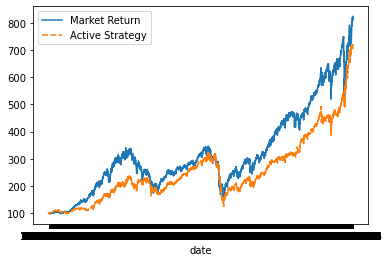

In [983]:
# create a graph that plots epochs vs. MSE
df = pd.DataFrame({'Market Return': s['market'],'Active Strategy': s['strategy']})
sns.lineplot(data=df);